# PyTorch Image Models Visualizer

There are numerous methods to understand a Convolutional Neural Network by visualizing it. But, most repositories/ libraries that implement these techniques only work for specific models such as a VGG/ Alexnet pretrained on ImageNet. The aim of this library is to provide a variety of visualization methods that work on any model trained on any dataset. The only requirement is that the model is an image classifier built with PyTorch. This library is pip-installable under the name "timm-vis". Note that this is NOT an official PyTorch library nor is it affiliated with Ross Wightman's [PyTorch Image Models](https://github.com/rwightman/pytorch-image-models) library. 

The 8 visualization techniques are described in detail below.

In [1]:
from timm_vis.methods import *
import timm

Throughout the notebook, an EfficientNet B0 pretrained on ImageNet and an image of a dog ("chow chow" - class 260) will be used.

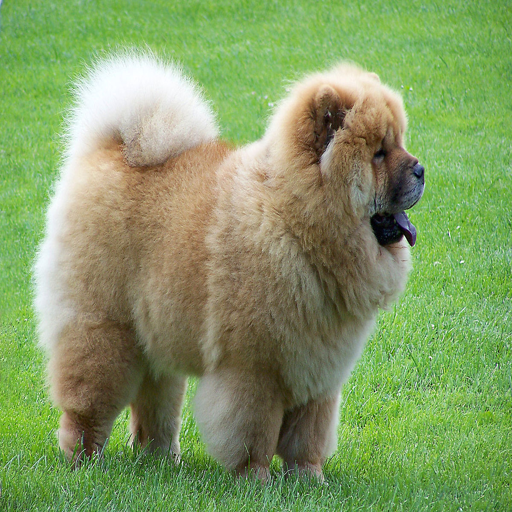

In [2]:
model = timm.create_model(model_name = 'efficientnet_b0', pretrained = True)
img = Image.open('chow.jpg').resize((512, 512))
img

## 1. Visualize filters

The __visualize_filters__ function plots the filters of a convolutional layer by interpreting each channel as a grayscale image. 

__Parameters__:
- <code>model</code>: PyTorch image classifier
- <code>filter_name</code>: name of the layer whose filters are visualized, defaults to first layer
- <code>max_filters</code>: maximum number of filters to be displayed, defaults to 64
- <code>size</code>: size to which filters are upsized to, defaults to 128
- <code>figsize</code>: size of the pyplot figure, defaults to (16, 16)
- <code>save_path</code>: path where generated plot is saved, defaults to None

Below, 25 filters of the second convolutional layer (named '<code>blocks.0.0.conv_dw.weight</code>') are plotted. The name of a layer can be found by iterating over <code>model.named_parameters()</code>. If the number of filters exceeds <code>max_filters</code>, <code>max_filters</code> random filters are plotted. 

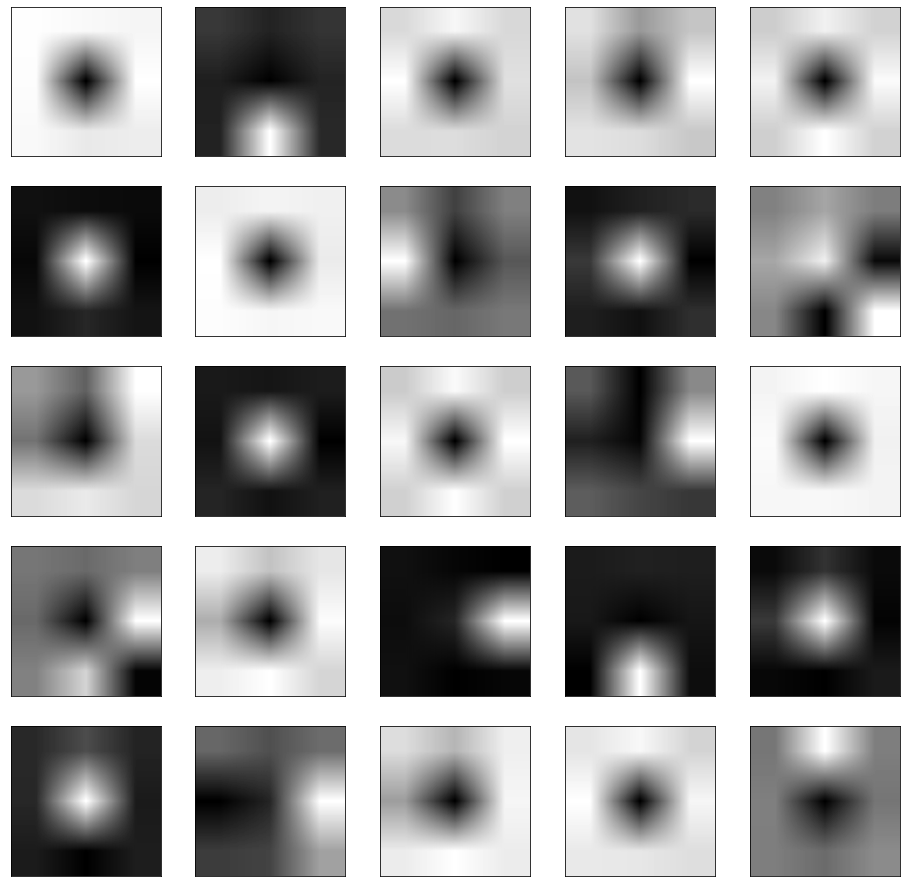

In [3]:
visualize_filters(model, 'blocks.0.0.conv_dw.weight', max_filters = 25)

## 2. Visualize activations

The __visualize_activations__ function plots the activations of a specific layer given a specific image. 

__Parameters__:
- <code>model</code>: PyTorch image classifier
- <code>module</code>: layer whose activations are recorded
- <code>img_path</code>: path to image
- <code>max_acts</code>: maximum number of activations to be displayed, defaults to 64
- <code>figsize</code>: size of the pyplot figure, defaults to (16, 16)
- <code>save_path</code>: path where generated plot is saved, defaults to None

The image at <code>img_path</code> is converted to a tensor and fed to the model. The outputs of <code>module</code> are stored and displayed. Each channel in the intermediate output tensor is interpreted as a grayscale image. Below are the activations of the model's first convolutional layer for the image of the dog.

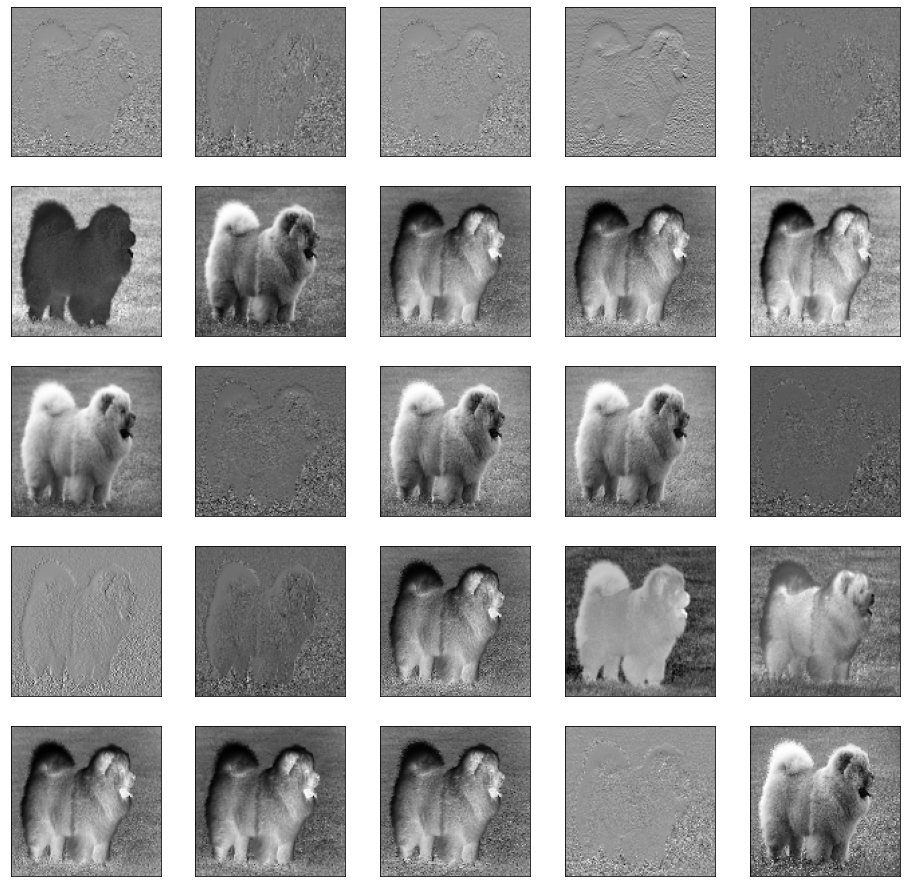

In [4]:
visualize_activations(model, model.conv_stem, 'chow.jpg')

## 3. Maximally Activated Patches

The __maximally_activated_patches__ function plots the patches of the image that produce the maximal activations at the last layer while performing a forward pass with that image. 

__Parameters__:
- <code>model</code>: PyTorch image classifier
- <code>img_path</code>: path to image
- <code>rgb</code>: True if number of input channels in the first convolution layer and input layer is 3, False otherwise
- <code>patch_size</code>: size of patch, defaults to 448
- <code>stride</code>: stride of the sliding patches, defaults to 100
- <code>num_patches</code>: number of patches
- <code>figsize</code>: size of the pyplot figure, defaults to (16, 16)
- <code>device</code>: device to use while computing patches, defaults to cuda
- <code>save_path</code>: path where generated plot is saved, defaults to None

To find the maximally activated patches, parts of the image (patches) are occluded. The occlusions that produce the largest change in the predicted scores for the top class are ranked higher than those that produce minimal changes. The top <code>num_patches</code> patches of the image are plotted. Below are the top 5 patches of the dog image.

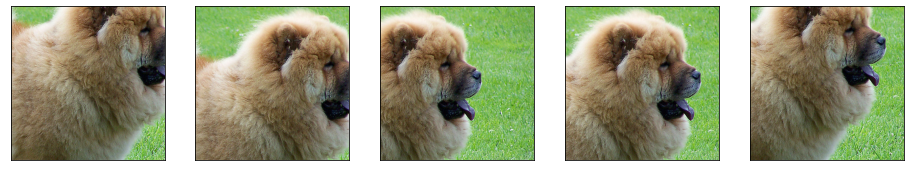

In [5]:
maximally_activated_patches(model, 'chow.jpg')

## 4. Saliency map

The __saliency_map__ function plots the gradient of the predicted score with respect to each pixel in the input image. 

__Parameters__:
- <code>model</code>: PyTorch image classifier
- <code>img_path</code>: path to image
- <code>rgb</code>: True if number of input channels in the first convolution layer and input layer is 3, False otherwise
- <code>figsize</code>: size of the pyplot figure, defaults to (16, 16)
- <code>device</code>: device to use while computing patches, defaults to cuda
- <code>save_path</code>: path where generated plot is saved, defaults to None

The gradient of the un-normalized class score is calculated with respect to the pixels in the image. The absolute value and maximum is taken over all three channels. Lighter parts of the map correspond with gradients of higher magnitude. Below is the saliency map of the dog image.

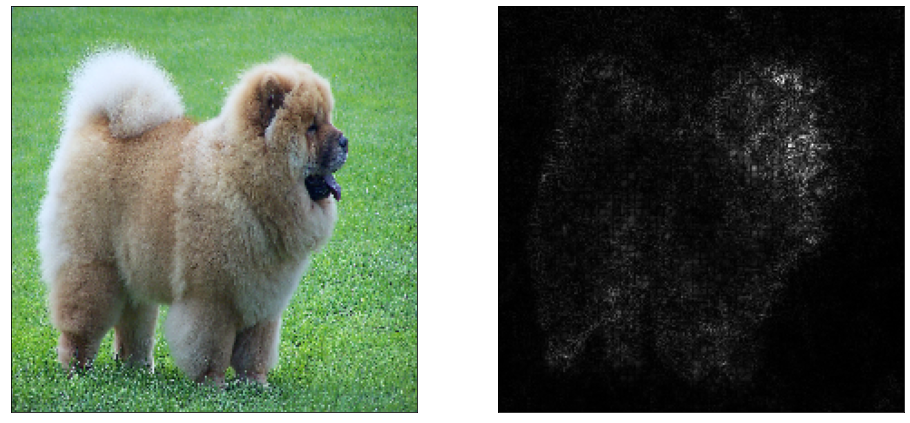

In [6]:
saliency_map(model, 'chow.jpg')

## 5. Generate synthetic image

The __generate_image__ function generates a synthetic image that maximizes the score of a specific class.

__Parameters__:
- <code>model</code>: PyTorch image classifier
- <code>target_class</code>: the class whose score is maximized
- <code>epochs</code>: number of epochs to execute gradient ascent for
- <code>min_prob</code>: minimum probability of the target class, gradient ascent is interrupted if the confidence score for target class is > min_prob
- <code>lr</code>: learning rate 
- <code>weight_decay</code>: weight decay used for L2 regularization
- <code>step_size</code>: step size for learning rate scheduler, defaults to 100
- <code>gamma</code>: gamma used for learning rate scheduler, defaults to 0.6
- <code>noise_size</code>: size of initial noise, defaults to 224
- <code>p_freq</code>: printing frequency, defaults to 50
- <code>init</code>: function used when initializing noise, defaults to torch.randn
- <code>model</code>: PyTorch image classifier
- <code>device</code>: device to use while computing patches, defaults to cuda
- <code>figsize</code>: size of the pyplot figure, defaults to (6, 6)
- <code>save_path</code>: path where generated plot is saved, defaults to None


The input to the model is initialized using the <code>init</code> function. A forward pass is performed in order to compute gradients of the target class with respect to the input. The input is changed in order to maximize the score of the target class. This process is repeated for <code>epochs</code> iterations or until the model predicts the target class with minimum probability <code>min_prob</code>. The function call below generates a synthetic image for which the model predicts class 130 (flamingo) with a confidence of ~0.91.

Epoch: 50 Confidence score for class 130: 0.08524773269891739
Epoch: 100 Confidence score for class 130: 0.6547715067863464
Reached 0.9365537762641907 confidence score in epoch 137. Stopping early.


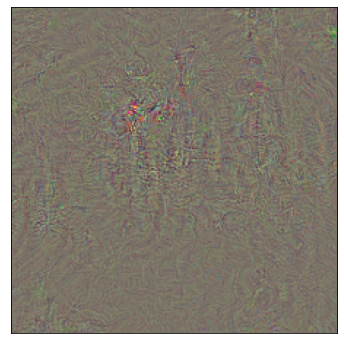

In [7]:
synthetic_image = generate_image(model = model, target_class = 130, epochs = 500, min_prob = 0.9, lr = 10, weight_decay = 5e-2, 
                        step_size = 100, gamma = 0.9)

## 6. Fool model

The __fool_model__ function modifies an input image such that the model's score for a target class is maximized.

__Parameters__:
- <code>model</code>: PyTorch image classifier
- <code>img_path</code>: path to image
- <code>rgb</code>: True if number of input channels in the first convolution layer and input layer is 3, False otherwise
- <code>target_class</code>: the class whose score is maximized
- <code>epochs</code>: number of epochs to execute gradient ascent for
- <code>min_prob</code>: minimum probability of the target class, gradient ascent is interrupted if the confidence score for target class is > min_prob
- <code>lr</code>: learning rate 
- <code>step_size</code>: step size for learning rate scheduler, defaults to 100
- <code>gamma</code>: gamma used for learning rate scheduler, defaults to 0.6
- <code>p_freq</code>: printing frequency, defaults to 50
- <code>init</code>: function used when initializing noise, defaults to torch.randn
- <code>model</code>: PyTorch image classifier
- <code>device</code>: device to use while computing patches, defaults to cuda
- <code>figsize</code>: size of the pyplot figure, defaults to (6, 6)
- <code>save_path</code>: path where generated plot is saved, defaults to None


The input image is modified through the same procedure used in the <code>generate_image</code> function. The only difference between the two methods is that this method inputs the image at <code>img_path</code> to the model instead of a random tensor. The function call below modifies the image of a chow chow only slightly. But, the model predicts that the modified image is of class 724 (pirate ship) with a high confidence.

Reached 0.9150859117507935 confidence score in epoch 38. Stopping early.


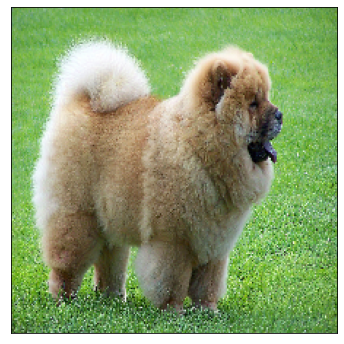

In [8]:
adv = fool_model(model = model, img_path = 'chow.jpg', target_class = 724, epochs = 500, 
                       min_prob = 0.9, lr = 5e-1, step_size = 100, gamma = 0.8)

Confirming that the model does predict the above image as class 724 (pirate ship):

In [9]:
model(adv).argmax()

tensor(724, device='cuda:0')

## 7. Feature inversion

The __feature_inversion__ function reconstructs an input image using intermediate feature representation of multiple modules.

__Parameters__:
- <code>model</code>: PyTorch image classifier
- <code>modules</code>: list of modules
- <code>img_path</code>: path to image
- <code>rgb</code>: True if number of input channels in the first convolution layer and input layer is 3, False otherwise
- <code>epochs</code>: number of epochs to execute gradient ascent for
- <code>lr</code>: learning rate 
- <code>step_size</code>: step size for learning rate scheduler, defaults to 100
- <code>gamma</code>: gamma used for learning rate scheduler, defaults to 0.6
- <code>mu</code>: regularization factor for total variation regularizer
- <code>device</code>: device to use while computing patches, defaults to cuda
- <code>figsize</code>: size of the pyplot figure, defaults to (6, 6)
- <code>save_path</code>: path where generated plot is saved, defaults to None


The feature vector of the input image from a module is recorded. Another image is generated that minimizes the sum of the distance between the feature vector of the recreated image and the feature vector of the original input image and the total variation regularizer (required for the image to look "natural"). Below are the outputs of the function when an image is reconstructured using the outputs of the first, second and last convolutional layer of the model. As seen below, earlier layers of the model tend to recreate images that closely resemble the input image. This shows that as the image is passes through the model, information is lost.

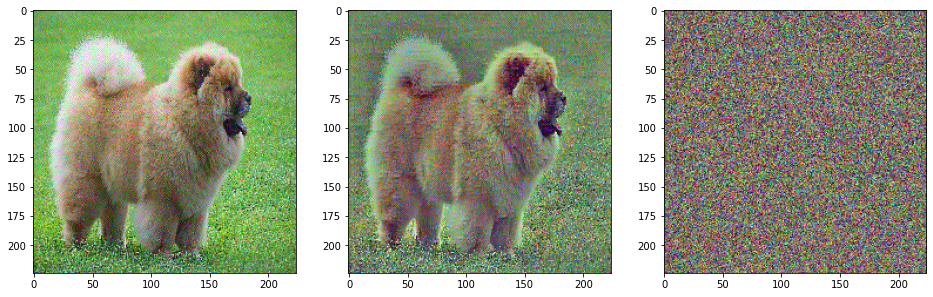

In [10]:
modules = [model.conv_stem, model.blocks[0][0].conv_dw, model.blocks[-1][0].conv_pwl]
feature_inversion(model, modules, 'chow.jpg', 100, 1e-3)

## 8. Grad-CAM

The __grad_cam__ function plots the Grad-CAM for a specific module and image.

__Parameters__:
- <code>model</code>: PyTorch image classifier
- <code>module</code>: module used, usually the last activation layer
- <code>img_path</code>: path to image
- <code>rgb</code>: True if number of input channels in the first convolution layer and input layer is 3, False otherwise
- <code>class_id</code>: id of class for which gradients are calculated
- <code>device</code>: device to use while computing patches, defaults to cuda
- <code>alpha</code>: super-imposition factor used, defaults to 0.6
- <code>figsize</code>: size of the pyplot figure, defaults to (6, 6)
- <code>save_path</code>: path where generated plot is saved, defaults to None

The module parameter is usually the last activation layer of the model. The below cell runs the grad_cam function on our dog image with a VGG16. The function will work for any model, but a VGG was chosen over the EfficientNet since it gives bettter visualizations.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


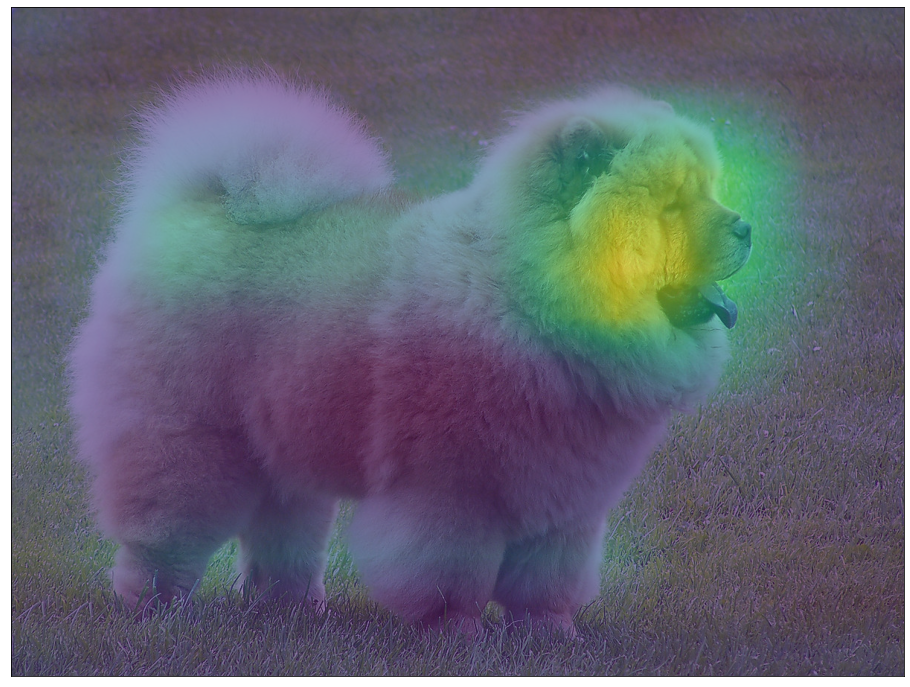

In [11]:
vgg = timm.create_model(model_name = 'vgg16', pretrained = True)
grad_cam(vgg, vgg.features[29], 'chow.jpg', 260)

## 9. Deep Dream

The __deep_dream__ function modifies an input image in order to maximize the activations  of an intermediate layer.

__Parameters__:
- <code>model</code>: PyTorch image classifier
- <code>module</code>: module whose outputs are maximized
- <code>img_path</code>: path to image
- <code>rgb</code>: True if number of input channels in the first convolution layer and input layer is 3, False otherwise
- <code>epochs</code>: number of epochs to execute gradient ascent for
- <code>lr</code>: learning rate 
- <code>step_size</code>: step size for learning rate scheduler, defaults to 100
- <code>gamma</code>: gamma used for learning rate scheduler, defaults to 0.6
- <code>device</code>: device to use while computing patches, defaults to cuda
- <code>figsize</code>: size of the pyplot figure, defaults to (12, 12)
- <code>save_path</code>: path where generated plot is saved, defaults to None

A given input image is modified in order to maximize the outputs of <code>module</code>. This is a very simplistic implementation of Deep Dream. For the same input image, the outputs of this function may vary depending on the model weights.

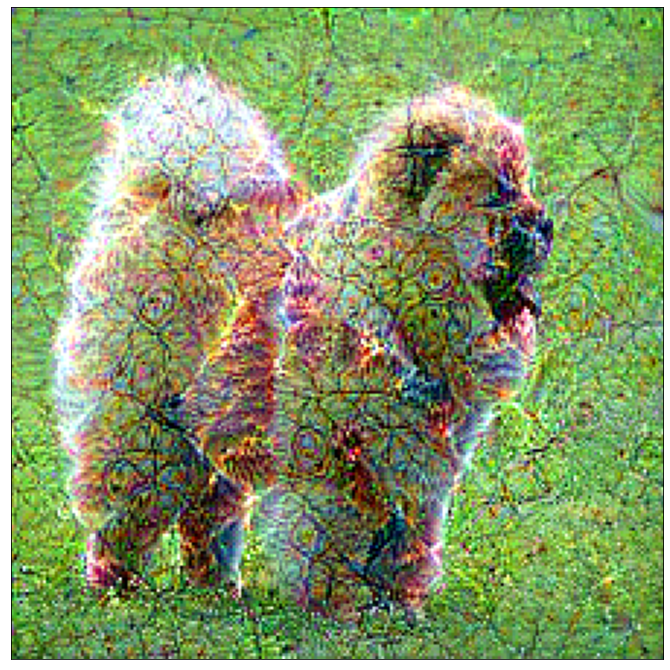

In [12]:
dream = deep_dream(model = model, module = model.blocks[-2][0].conv_dw
                             , img_path = 'chow.jpg', epochs = 100, lr = 2)

The above functions will work for any PyTorch image classifier. However, you may have to use different hyperparameters for various models and functions. If you notice any bugs or missing citations or have any feedback, code optimizations or feature requests, please inform me through GitHub.